# **IBM Data Science Project** #

## **Business Problem**

**This report will provide an in-depth analysis of an ideal location or locations to open an authentic Italian pizza restaurant in the growing city of Austin, TX. An analysis and recommendation will be made, provided by data courtesy of Foursquare. Any capitalist looking to invest in an Italian restaurant in the Austin, TX area may find this analysis quite useful.**

**When opening a restaurant there are many different factors to consider (food/menu choice, alcohol availability, real estate, location, local competition or market saturation, economic indicators, and pricing to name a few). The city of Austin, TX is recognized as one of the fastest growing cities in the USA and consistently ranked as one of the best places to live in the country as well. Dubbed the next 'Silicon Valley, it provides superior cost of living, tax incentives, and a large artistic hub that attracts young talent and large businesses such as Google, Dell, and Apple. The restaurant business itself is highly competitive and cut-throat. This is why market research is necessary to mitigate risk before taking on such a significant financial risk, especially when its a well-known fact that approximately 90% of restaurants fail within the first year.**

## **Data Overview**

**Using data provided by Foursquare and other credible data providers, the best tract or neighborhood to open up an authentic Italian restaurant will be recommended based on the following factors:**

-  **Location (local competition, nearby entertainment such as bars, proximity to city).** <br>
-  **Economic indicators (average household income in each neighborhood).** <br>
-  **Competition (local restaurants offering same product).** <br>
-  **Target market, area population, and market size.** <br>

**Data sources will include the web (web scraping), downloadable CSV’s, and a publically available GeoJSON file of the cities boundaries. Population data will be scraped from http://zipatlas.com/us/tx/austin/zip-code-comparison/population-density.htm. Downloadable .CSV will correlate neighborhoods to each zip code, a geolocater library to determine exact coordinates of each zip code/neighbhorhood, and finally, Foursquare will be utilized to obtain and filter out venue categories by competition based on location. A final DataFrame combining all the desired data will be constructed to compare all the different factors mentioned above. A conclusion will be made based on this data.**

**This analysis will provide a recommendation based on the factors listed above. There are, however, plenty of other factors one should consider before opening a restaurant, for instance: initial capital, management team, marketing & advertisement, equipment costs, design, and professional fee’s to name a few.**

**NOTE: In order to understand data processing logic, comments have been made throughout Data Preparation Section.**

## **Methodology**

**1. Business Understanding** <br>
**2. Analytical Approach - Decision Analytics** <br>
**3. Data Requirement - Population, Income, Competition, Location** <br>
**4. Data Collection - Descriptive Statistics & Visualization** <br>
**5. Data Preparation - Data Processing** <br>
**6. Modeling - Descriptive** <br>
**7. Evaluation - Statistical** <br>

## **Data Collection**

### **1. Import Required Modules & Libraries.**

In [1]:
import numpy as np
################################################################################################
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
################################################################################################
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance # outputs distance between 2 locations
################################################################################################
import requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
################################################################################################
import os, sys
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
################################################################################################
!conda install -c conda-forge geocoder -y
#import geocoder
################################################################################################
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
################################################################################################
# Import k-means from clustering stage
from sklearn.cluster import KMeans
################################################################################################
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
################################################################################################
print('Libraries imported.')

Libraries imported.


### **2. Web Scraping / Cleaning Data**

**Use BeautifulSoup (BS4) to scrape and download web data on Austin population by Zip Code, and convert to pandas DataFrame. (Note: Data is from last national census collection conducted in 2010.)**

In [3]:
# Web Scraping Source
pop_source = requests.get("http://zipatlas.com/us/tx/austin/zip-code-comparison/median-household-income.htm").text

soup = BeautifulSoup(pop_source, 'html5lib')
source = soup.find_all('td',class_ = 'report_data')

# Create empty data frame to append values to.
austin_pop = pd.DataFrame(columns=['Zip Code','Location','Population','Average Income'])

# Loop and append all Zip Code and Population data into the empty dataframe.
def chunks(l, n):
    for i in range(0, len(row_data), n):
        yield row_data[i:i+n]
row_data = [data.text for data in source]
rows_data = list(chunks(row_data, 7))

for row in rows_data:
    temp_df = pd.DataFrame([row], columns=['#','Zip Code','Location','City', 'Population','Average Income','National Rank'])
    temp_df = temp_df[['Zip Code','Location','Population','Average Income']]
    austin_pop = austin_pop.append(temp_df).reset_index(drop=True)

# Cleaning Data - Remove commas in string, convert values to int. Remove all rows with Population of 0.
austin_pop['Population'] = austin_pop['Population'].str.replace(",","").astype(int)
austin_pop = austin_pop[austin_pop.Population != 0].reset_index(drop=True)

# Cleaning Data - Remove commas and $ in Average Income column
austin_pop['Average Income'] = austin_pop['Average Income'].str.replace(',', '')
austin_pop['Average Income'] = austin_pop['Average Income'].str.replace('\$', '')
austin_pop['Average Income'] = austin_pop['Average Income'].astype(float)
austin_pop['Average Income'] = austin_pop['Average Income'].astype(int)

# Cleaning Data - Split Location into Latitude and Longitude columns and remove Location Column
Latitude = []
Longitude = []
for row in austin_pop['Location']:
    try:
        Latitude.append(row.split(',')[0])
        Longitude.append(row.split(',')[1])
    except:
        pass
austin_pop['Latitude'] = Latitude
austin_pop['Longitude'] = Longitude
austin_pop.drop(['Location'],axis=1, inplace=True)

# Add Column '% of Population' to DataFrame and Sort values by Descending
austin_pop['Population'].iloc[33]=12000
austin_pop['% of Population']=austin_pop['Population']/austin_pop.Population.sum()
austin_pop['% of Population'] = pd.Series(["{0:.2f}%".format(val * 100) for val in austin_pop['% of Population']])
austin_pop=austin_pop.sort_values(by=['% of Population'], ascending=False).reset_index(drop=True)
austin_pop = austin_pop.reindex(['Zip Code','Latitude','Longitude','Population','% of Population','Average Income'], axis=1)

In [4]:
# Download file corresponding each Austin Neighborhood with a Zip-Code and merge it to Population DataFrame
path = r'austinpop.csv'
zip_neighborhood = pd.read_csv(path)
zip_neighborhood['Zip Code']=zip_neighborhood['Zip Code'].astype('str')
df_austin = pd.merge(austin_pop,zip_neighborhood, on='Zip Code')
df_austin.head()

,Zip Code,Latitude,Longitude,Population,% of Population,Average Income,Neighborhood
0,78745,30.206806,-97.797108,53044,6.73%,43458,Sweetbriar
1,78745,30.206806,-97.797108,53044,6.73%,43458,West Congress
2,78745,30.206806,-97.797108,53044,6.73%,43458,Garrison Park
3,78745,30.206806,-97.797108,53044,6.73%,43458,South Manchaca
4,78745,30.206806,-97.797108,53044,6.73%,43458,West Gate


**The web source did not provide accurate location data. Therefore, a loop is created below using a geolocator for more precise location coordinates. These modified locations will be used for folium mapping (adding markers). Also the web source grouped a few nearby areas together. The names of these areas are changed for Nominatim compatibility.**

In [5]:
# Create new DataFrame to house modified location values.
df_austin2 = pd.DataFrame(columns=['Mod_Neighborhood','Mod_Latitude','Mod_Longitude'])
# Replace grouped Neighborhood names
df_austin2['Mod_Neighborhood'] = df_austin['Neighborhood'].replace({'Pecan-Springdale':'Pecan Springs Springdale',
                                                                    'Pemberton Heights and Bryker Woods':'Bryker Woods',
                                                                    'North Loop/Ridgetop':'North Loop','Wilshire/Delwood':
                                                                    'Delwood'})

In [6]:
# Add 'Austin, TX' for Nominatim compatability
address = df_austin2['Mod_Neighborhood']+', Austin, Texas'
# Loop through all Neighborhood names for Coordinates
lt=[]
ln=[]
for i in range(len(df_austin)):
    try:
        geolocator = Nominatim(user_agent = "austin_explorer")
        location = geolocator.geocode(address[i])
        mod_latitude=location.latitude
        mod_longitude=location.longitude
    except:
        mod_latitude = df_austin['Latitude'][i]
        mod_longitude = df_austin['Longitude'][i]
    lt.append(mod_latitude)
    ln.append(mod_longitude)
df_austin2['Mod_Latitude']=lt
df_austin2['Mod_Longitude']=ln

In [7]:
# Adjust Location coordinates for Oak Springs
df_austin2['Mod_Latitude'].iloc[64]= 30.2357
df_austin2['Mod_Longitude'].iloc[64]= -97.8395

## **Data Preparation**

### **3. Folium Mapping** ###

**Download GeoJson file publicly available on Github. Using folium, Choropleth maps of Austin's population and income are generated. In order to view outside a Jupyter notebook, a snapshot of the rendered maps were uploaded.**

In [8]:
austin_geo = r'austin.geojson'

austin_pop_map = folium.Map(location=[30.3, -97.7430608], zoom_start=11, width =750, height =500)  
austin_income_map = folium.Map(location=[30.3, -97.7430608], zoom_start=11, width =750, height =500)  

In [9]:
#Austin Population Density Map
austin_pop_map.choropleth(
    geo_data=austin_geo,
    data = df_austin,
    columns=['Neighborhood', 'Population'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Austin Residential Population Density'
)
austin_pop_map

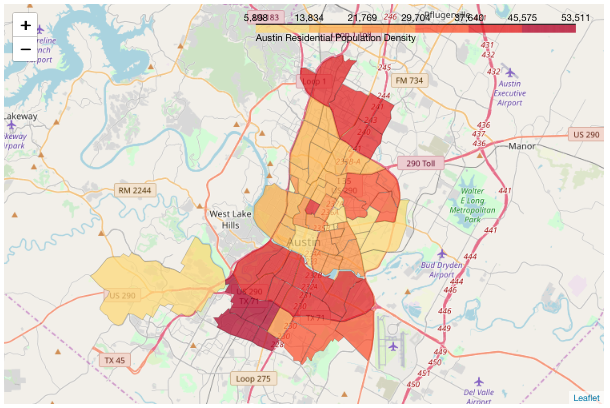

In [10]:
from IPython.display import Image
Image(filename='img1.png') 

In [11]:
#Austin Average Residential Income by Neighborhood 
austin_income_map.choropleth(
    geo_data=austin_geo,
    data = df_austin,
    columns=['Neighborhood', 'Average Income'],
    key_on='feature.properties.name',
    fill_color='GnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Austin Average Income by Household'
)
austin_income_map

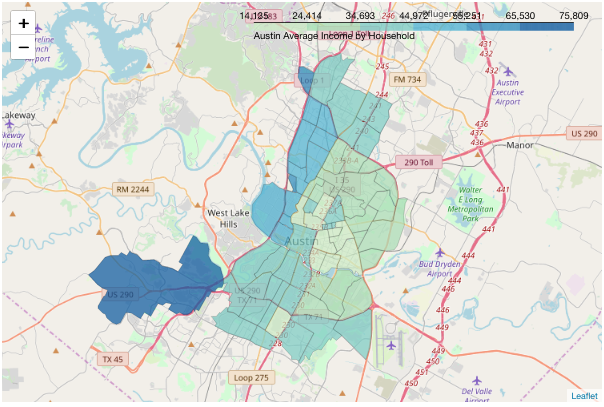

In [12]:
Image(filename='img2.png') 

**Neighborhood and Zip Code markers are overlayed onto Population map below.**

In [13]:
#Convert cooridnates into float type.
df_austin2['Mod_Latitude'] = df_austin2['Mod_Latitude'].astype(float)
df_austin2['Mod_Longitude'] = df_austin2['Mod_Longitude'].astype(float)

In [14]:
for lat, lng, Zip_Code, Neighborhood in zip(df_austin2['Mod_Latitude'], df_austin2['Mod_Longitude'],
                                            df_austin['Zip Code'], df_austin['Neighborhood']):
    label = '{},{}'.format(Neighborhood,Zip_Code)
    labels = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2.5,
        popup=labels,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5,
        parse_html=False).add_to(austin_pop_map)  
    
austin_pop_map

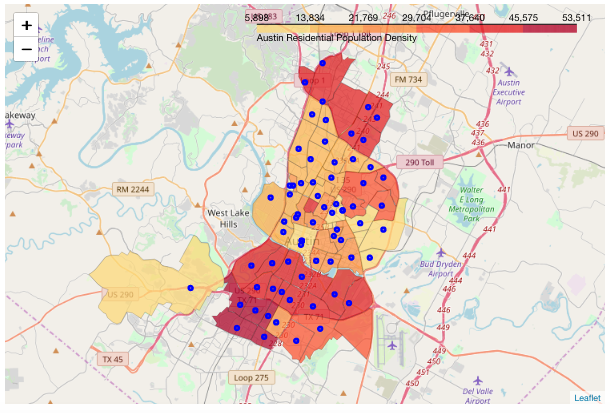

In [15]:
Image(filename='img3.png') 

### **4. Foursquare API**

**Import Foursquare credentials. Hidden for security.**

In [16]:
CLIENT_ID = 'INSERT CLIENT ID' 
CLIENT_SECRET = 'INSERT CLIENT SECRET'
VERSION = '20180605'

**Venue limit of 100 and radius of 1609 m (1 mile) defined. Below is a function that returns venue information such as name, latitude, longitude, and venue category from Foursquare based on input longitude and latitude values.**

In [17]:
LIMIT = 100
radius = 1609
def getNearbyVenues(names, f_latitudes, f_longitudes, radius=radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, f_latitudes, f_longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude',
                             'Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [18]:
Austin_Venues = getNearbyVenues(names=df_austin['Neighborhood'],f_latitudes=df_austin2['Mod_Latitude'],
                                f_longitudes=df_austin2['Mod_Longitude'])

**Unique venue categories examined to determine categories of interest. 'Italian Restaurant', 'Pizza Place', and 'Restaurant' are chosen. Italian Restaurant because it's direct competition, Pizza Place because pizza is one of the most popular Italian dishes, and Restaurant because other high end restaurants will also be considered as competition.**

In [19]:
# Examine list of unique venue categories to determine competition
x=Austin_Venues['Venue Category'].unique()
np.array(x).tolist();

**All Italian venues are chosen and the number of venues in eaach neighborhood are determined. The total number of competitive venues is determined to be 290 and the top 5 areas/neighborhoods with the most competition are listed below.**

In [20]:
#Locate all Italian venues in the Austin area.
Italian_Venues=Austin_Venues.loc[(Austin_Venues['Venue Category'].values == "Italian Restaurant")|
                  (Austin_Venues['Venue Category'].values == "Pizza Place")|
                  (Austin_Venues['Venue Category'].values == "Restaurant")]

In [21]:
#Group and Count number of Italian venues for each neighborhood. Sort in descending order.
Italian = Italian_Venues.groupby('Neighborhood',as_index=False).count()
Italian = Italian.sort_values('Venue Category',ascending=False)

In [22]:
print('There are', len(Italian_Venues),'competetive venues to an Italian Restaurant in Austin, TX')
print('Top 5 areas with most competition are Sweetbriar, Travis Heights, Ridgelea, Rosedale, & Downtown')

There are 290 competetive venues to an Italian Restaurant in Austin, TX
Top 5 areas with most competition are Sweetbriar, Travis Heights, Ridgelea, Rosedale, & Downtown


In [23]:
#Create new Dataframe to compare Neighborhood,Venue Count, Population, and Income
merge1=Italian.filter(['Neighborhood','Venue'], axis=1)
merge2=df_austin.filter(['Neighborhood','Population','Average Income'],axis=1)
Competition = pd.merge(merge1,merge2, on='Neighborhood');

### **5. Statistical and Data Analysis**

**One Hot Encoding method is used to determine frequency of Competitive Venues in each Neighborhood of Austin, TX.**

In [24]:
# One Hot Encoding
austin_onehot = pd.get_dummies(Austin_Venues[['Venue Category']], prefix="", prefix_sep="")

# Add Neighborhood column back to DataFrame
austin_onehot['Neighborhood'] = Austin_Venues['Neighborhood'] 

# Move Neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

# Group rows by Neighborhood, take mean frequency of each venue category and filter by Italian Restaurant, Pizza Place, and Restaurant columns
austin_grouped = austin_onehot.groupby('Neighborhood').mean().reset_index()

# Create total frequency column for each Neighborhood
austin_grouped1 = austin_grouped.filter(['Neighborhood','Italian Restaurant','Pizza Place','Restaurant'])
austin_grouped1['Venue Frequency']=austin_grouped1['Italian Restaurant']+austin_grouped1['Pizza Place']+austin_grouped1['Restaurant']
austin_grouped1.drop(['Italian Restaurant','Pizza Place','Restaurant'],axis=1, inplace=True)

# Merge new DataFrame with Competition Dataframe above
Competition_New = pd.merge(Competition,austin_grouped1, on='Neighborhood')
Competition_New.sort_values('Venue Frequency', ascending=False).reset_index(drop=True);

**Statistical Conditions are defined to filter resulting data. The new DataFrame (Comp_New) shows all Neighborhoods with a Population >= mean Population, Average Income >= mean Average Income, and Venue Frequency <= mean Venue Frequency.**

In [25]:
Competition_New.describe()

,Venue,Population,Average Income,Venue Frequency
count,64.000000,64.000000,64.000000,64.000000
mean,4.531250,29250.218750,36929.156250,0.051146
std,2.137858,13833.776844,11924.960804,0.021665
min,1.000000,6365.000000,14740.000000,0.016393
25%,3.000000,19585.000000,29779.000000,0.037054
50%,4.000000,25442.000000,35745.000000,0.047727
75%,6.000000,43249.000000,43458.000000,0.070000
max,10.000000,53044.000000,75204.000000,0.107143


In [26]:
#Refine DataFrame with statistical conditions
Comp_New=Competition_New.loc[(Competition_New['Population'] >= Competition_New['Population'].mean()) & (Competition_New['Average Income'] >= Competition_New['Average Income'].mean())
                     & (Competition_New['Venue Frequency'] <= Competition_New['Venue Frequency'].mean())]
Comp_New.reset_index(drop=True);

**The distance to Downtown Austin is figured for the 8 resulting neighborhoods. This is very important to know due to the influx of traffic in and out of the city. If the neighborhood is closer to the city, this can potentially translate into increased business due to a convenience factor.**

In [27]:
address = 'Downtown, Austin, TX'

geolocator = Nominatim(user_agent="austin_explorer")
location_austin = geolocator.geocode(address)
austin_city_latitude = location_austin.latitude
austin_city_longitude = location_austin.longitude
print('The geograpical coordinate of Austin, TX are {}, {}.'.format(austin_city_latitude, austin_city_longitude))
location_austin = (austin_city_latitude, austin_city_longitude)

The geograpical coordinate of Austin, TX are 30.2680536, -97.7447642.


In [28]:
# Create a dataframe of Coordinate Values to merge with above DataFrame. Clean DataFrame
merge3 = df_austin2.filter(['Mod_Neighborhood','Mod_Latitude','Mod_Longitude'])
merge3.rename(columns={'Mod_Latitude':'Latitude','Mod_Longitude':'Longitude'}, inplace=True)
merge3.reset_index()
merge3.rename(columns={'Mod_Neighborhood':'Neighborhood'},inplace=True)
merge3['Coordinates'] = merge3[["Latitude","Longitude"]].values.tolist()
distance_df=Comp_New.merge(merge3, on='Neighborhood',how= 'inner')
distance_df

,Neighborhood,Venue,Population,Average Income,Venue Frequency,Latitude,Longitude,Coordinates
0,West Gate,4,53044,43458,0.040000,30.223210,-97.797043,"[30.2232099, -97.7970429]"
1,Gateway,4,40547,61284,0.040000,30.388153,-97.740959,"[30.3881525, -97.7409588016711]"
2,Georgian Acres,4,44210,38206,0.040000,30.350096,-97.701756,"[30.3500963, -97.7017559]"
3,North Austin,4,42820,42398,0.040000,30.402330,-97.726009,"[30.4023299, -97.7260086]"
4,North Burnet,3,42820,42398,0.041096,30.374185,-97.726056,"[30.3741853, -97.7260555]"
5,North Campus,2,42820,42398,0.020000,30.287986,-97.748617,"[30.2879855, -97.7486168]"
6,South Manchaca,2,53044,43458,0.028169,30.219541,-97.783883,"[30.219541, -97.7838832]"
7,West Congress,1,53044,43458,0.016393,30.215382,-97.772770,"[30.2153822, -97.7727705]"


In [29]:
# Loop through all Neighborhoods to calculate distance to the city in miles
Distance_To_Austin=[]
for x in range(len(Comp_New)):
    neighborhoods = distance_df['Coordinates'][x]
    distance = geopy.distance.vincenty(location_austin,neighborhoods).miles
    Distance_To_Austin.append(distance)
Comp_New['Distance to Austin - Miles'] = Distance_To_Austin
Comp_New.reset_index(drop=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Neighborhood,Venue,Population,Average Income,Venue Frequency,Distance to Austin - Miles
0,West Gate,4,53044,43458,0.040000,4.395125
1,Gateway,4,40547,61284,0.040000,8.276013
2,Georgian Acres,4,44210,38206,0.040000,6.208527
3,North Austin,4,42820,42398,0.040000,9.317137
4,North Burnet,3,42820,42398,0.041096,7.395760
5,North Campus,2,42820,42398,0.020000,1.392164
6,South Manchaca,2,53044,43458,0.028169,4.079285
7,West Congress,1,53044,43458,0.016393,3.996150


**Below is a map of the Austin area. Blue points indicate the location of the interested Neighborhoods and the Red points indicate competition location. 2 markers have been added in as the recommended locations to open an Italian Restaurant based on the data. These 2 locations are North Campus and West Congress.**

In [30]:
Italian_Venues_map = folium.Map(location=[30.3, -97.7430608], zoom_start=11, width =750, height =500)  
for lat, lng, Neighborhood in zip(distance_df['Latitude'],distance_df['Longitude']
                                  , distance_df['Neighborhood']):
    label = '{}'.format(Neighborhood)
    labels = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius=2.5, popup=labels, color='blue', fill=True, fill_color='blue',
        fill_opacity=0.5, parse_html=False).add_to(Italian_Venues_map)  

lat2=distance_df['Latitude'].iloc[5]
lng2=distance_df['Longitude'].iloc[5]
nei2=distance_df['Neighborhood'].iloc[5]
folium.Marker(location=[lat2, lng2], icon=None, popup=nei2).add_to(Italian_Venues_map)
lat3=distance_df['Latitude'].iloc[7]
lng3=distance_df['Longitude'].iloc[7]
nei3=distance_df['Neighborhood'].iloc[7]
folium.Marker(location=[lat3, lng3], icon=None, popup=nei3).add_to(Italian_Venues_map)

In [31]:
Result_Venues = getNearbyVenues(names=distance_df['Neighborhood'],f_latitudes=distance_df['Latitude'],
                                f_longitudes=distance_df['Longitude'])
Result_Italian_Venues=Result_Venues.loc[(Result_Venues['Venue Category'].values == "Italian Restaurant")|
                  (Result_Venues['Venue Category'].values == "Pizza Place")|
                  (Result_Venues['Venue Category'].values == "Restaurant")]

for lat1, lng1, Venues in zip(Result_Italian_Venues['Venue Latitude'],Result_Italian_Venues['Venue Longitude']
                                  , Result_Italian_Venues['Venue']):
    label = '{}'.format(Venues)
    labels = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat1, lng1], radius=2.5, popup=labels, color='red', fill=True, fill_color='red',
        fill_opacity=0.5, parse_html=False).add_to(Italian_Venues_map) 

Italian_Venues_map

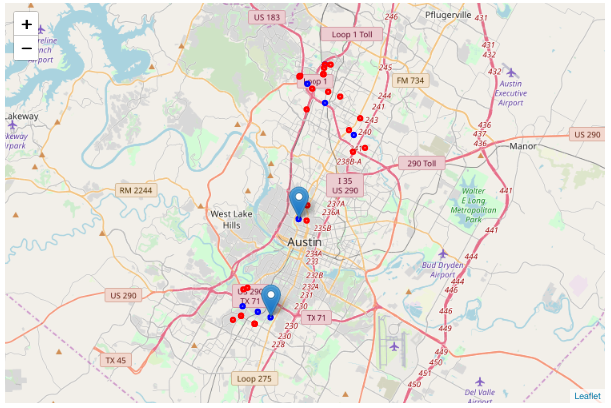

In [32]:
Image(filename='img4.png') 

## **Results & Discussion**

**It's a well known fact to those familiar with Austin, that the inner city commute is very poor. For that reason, choosing a location with a high population and close proximity to the city is important. From the analysis above, 2 locations would prove to be a prime location to open up a high-end authentic Italian Restaurant. *North Campus and West Congress*. Both have high Population, high Average Household Income, low Competition, and are close to the city. Average Income was also considered a key metric due to type of restaurant. Knowing your audience and customer is key to any business. A high end restaurant can be thought of as a luxury good, so households with higher income will likely spend more money on quality of service and food.**

## **Conclusion**

**Once again, in the case of a capital investment in such an opportunity, it's necessary to consider many other factors. This recommendation is based off of a few key factors including Population, Average Income, Competition, and Proximity to a city that is home to a huge tech scene, unique food, and young culture.**